In [ ]:
!unzip /content/drive/MyDrive/COVID.zip -d ../content

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd /content/COVID-19_Radiography_Dataset

/content/COVID-19_Radiography_Dataset


In [4]:
import os

In [5]:
for dirpath, dirnames, files in os.walk('/content/COVID-19_Radiography_Dataset'):
    print(dirnames)
    break

['Viral Pneumonia', 'Normal', 'COVID', 'Lung_Opacity']


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers,Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import MaxPool2D,Dense,Dropout,Flatten,Input,Conv2D,Conv2DTranspose,BatchNormalization,MaxPooling2D,concatenate
from tensorflow.keras.utils import to_categorical 
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator

preparing the data

In [7]:
labels = {1:'Covid',3:'Lung_Opacity',2:'Normal',0:'Viral_Pneumonia'}

In [8]:
A=[]   ### empty numpy arrays to input image data
B=[]   ### empty numpy arrays for Label data
label_maps = []

In [9]:
import PIL
from PIL import Image

In [10]:
import glob
import gc
import cv2
for i in range(len(dirnames)):
 if dirnames[i]=='COVID':
  label = 1
  images_directory = os.path.join('/content/COVID-19_Radiography_Dataset',dirnames[i],'images')
  images =  glob.glob(os.path.join(images_directory,'**/*.png'))
  j = 0
  for image in images:
    j=j+1
    img = Image.open(image)
    img=img.convert('RGB')
    img=img.resize((128,128))
    img=np.array(img)
    if j<=1000:
       A.append(img)
       label_maps.append(label)
  del image,img
 if dirnames[i]=='Viral Pneumonia':
  label = 0
  images_directory = os.path.join('/content/COVID-19_Radiography_Dataset',dirnames[i],'images')
  images =  glob.glob(os.path.join(images_directory,'**/*.png'))
  j = 0
  for image in images:
    j=j+1
    img = Image.open(image)
    img=img.convert('RGB')
    img=img.resize((128,128))
    img=np.array(img)
    if j<=1000:
       A.append(img)
       label_maps.append(label)
  del image,img
 if dirnames[i]=='Lung_Opacity':
  label = 3
  images_directory = os.path.join('/content/COVID-19_Radiography_Dataset',dirnames[i],'images')
  images =  glob.glob(os.path.join(images_directory,'**/*.png'))
  j = 0
  for image in images:
    j=j+1
    img = Image.open(image)
    img=img.convert('RGB')
    img=img.resize((128,128))
    img=np.array(img)
    if j<=1000:
       A.append(img)
       label_maps.append(label)
  del image,img
 if dirnames[i]=='Normal':
  label = 2
  images_directory = os.path.join('/content/COVID-19_Radiography_Dataset',dirnames[i],'images')
  images =  glob.glob(os.path.join(images_directory,'**/*.png'))
  j = 0
  for image in images:
    j=j+1
    img = Image.open(image)
    img=img.convert('RGB')
    img=img.resize((128,128))
    img=np.array(img)
    if j<=1000:
       A.append(img)
       label_maps.append(label)
  del image,img

In [11]:
print(len(A))
print(len(label_maps))

4000
4000


In [12]:
X_train,X_test,y_train,y_test = train_test_split(A,label_maps,test_size = 0.2,random_state =2)

In [13]:
del A,B
gc.collect()

469

In [14]:
x_train=np.array(X_train)
del X_train
x_test=np.array(X_test)
del X_test
Y_train=np.array(y_train).reshape((-1,1))
Y_test=np.array(y_test).reshape((-1,1))
del y_train, y_test
gc.collect()

88

In [15]:
print(x_train.shape)
print(x_test.shape)


(3200, 128, 128, 3)
(800, 128, 128, 3)


Model for Classification

In [16]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Activation
import tensorflow

using VGG pretrained model as encoder 


In [ ]:
#model = tensorflow.keras.models.Sequential([  
#model = tensorflow.keras.models.Sequential([  
#Conv2D(64,3,padding = 'same',activation='relu',input_shape = (128,128,3)),
#Conv2D(64,3,padding = 'same',activation='relu'),
#MaxPool2D((2,2)),
#Conv2D(128,3,padding = 'same',activation='relu'),
#Conv2D(128,3,padding = 'same',activation='relu'),
#MaxPool2D((2,2)),
#Conv2D(256,3,padding = 'same',activation='relu'),
#Conv2D(256,3,padding = 'same',activation='relu'),
#Conv2D(256,3,padding = 'same',activation='relu'),
#MaxPool2D((2,2)),
#Conv2D(512,3,padding = 'same',activation='relu'),
#Conv2D(512,3,padding = 'same',activation='relu'),
#Conv2D(512,3,padding = 'same',activation='relu'),
#MaxPool2D((2,2)),
#Conv2D(512,3,padding = 'same',activation='relu'),
#Conv2D(512,3,padding = 'same',activation='relu'),
#Conv2D(512,3,padding = 'same',activation='relu'),
#MaxPool2D((2,2)),
#Flatten(),
#layers.Dense(2000,activation='relu'),
#layers.Dense(1000,activation = 'relu'),
#layers.Dense(4,activation='softmax')])
#model.summary()

In [44]:
from tensorflow.keras import applications
from tensorflow.keras.layers import Input

# Loading without top layers, since you only need convolution. Note that by not
# specifying the shape of top layers, the input tensor shape is (None, None, 3),
# so you can use them for any size of images.
vgg_model = applications.VGG16(weights='imagenet', include_top=False)

# If you want to specify input tensor shape, e.g. 256x256 with 3 channels:
input_tensor = Input(shape=(128,128, 3))
vgg_model = applications.VGG16(weights='imagenet',
                               include_top=False,
                               input_tensor=input_tensor)
for layer in vgg_model.layers[:15]:
    layer.trainable = False
input = Flatten()(vgg_model.output)
#model.add(Flatten()(input)),
x = Dense(1024,activation = 'relu')(input)
x = Dense(256,activation = 'relu')(x)
output = Dense(4,activation = 'softmax')(x)

VGG_model = Model(inputs = vgg_model.input,outputs = output)
# To see the models' architecture and layer names, run the following
VGG_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

In [45]:
VGG_model.compile(loss='sparse_categorical_crossentropy',
              optimizer= Adam(learning_rate=0.0001),
              metrics=['accuracy'])

In [47]:
history = VGG_model.fit(x_train,Y_train,validation_data=(x_test,Y_test),steps_per_epoch = 150,batch_size=16,validation_steps = 30,
                     epochs=20)

Epoch 1/20
150/150 [==============================] - 8s 44ms/step - loss: 0.0308 - accuracy: 0.9900 - val_loss: 0.3808 - val_accuracy: 0.8979
Epoch 2/20
150/150 [==============================] - 7s 46ms/step - loss: 0.0123 - accuracy: 0.9958 - val_loss: 0.3269 - val_accuracy: 0.9229
Epoch 3/20
150/150 [==============================] - 7s 44ms/step - loss: 0.0027 - accuracy: 0.9992 - val_loss: 0.2751 - val_accuracy: 0.9333
Epoch 4/20
150/150 [==============================] - 7s 44ms/step - loss: 0.0013 - accuracy: 0.9996 - val_loss: 0.3939 - val_accuracy: 0.9375
Epoch 5/20
150/150 [==============================] - 7s 44ms/step - loss: 1.9556e-04 - accuracy: 1.0000 - val_loss: 0.3498 - val_accuracy: 0.9271
Epoch 6/20
150/150 [==============================] - 7s 44ms/step - loss: 5.7956e-05 - accuracy: 1.0000 - val_loss: 0.3849 - val_accuracy: 0.9417
Epoch 7/20
150/150 [==============================] - 7s 45ms/step - loss: 2.7956e-05 - accuracy: 1.0000 - val_loss: 0.4177 - val_accu

In [48]:
VGG_model.save('model_classification.h5')

In [49]:
Predictions=VGG_model.predict(x_test)

In [50]:
Predictions[0]

array([3.2500761e-19, 1.3457280e-13, 3.2749553e-11, 1.0000000e+00],
      dtype=float32)

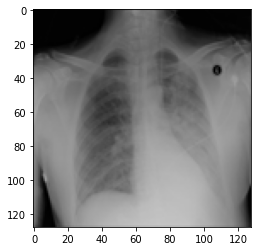

disease detected :Lung_Opacity
Actual disease :Lung_Opacity


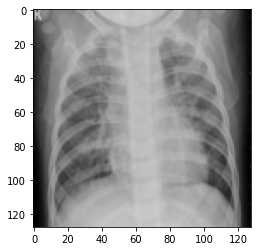

disease detected :Viral_Pneumonia
Actual disease :Viral_Pneumonia


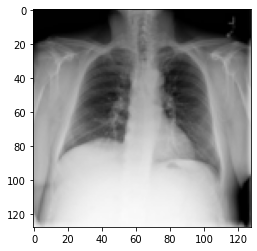

disease detected :Normal
Actual disease :Normal


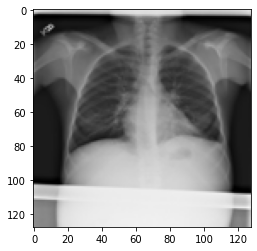

disease detected :Normal
Actual disease :Lung_Opacity


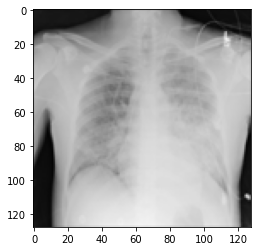

disease detected :Lung_Opacity
Actual disease :Lung_Opacity


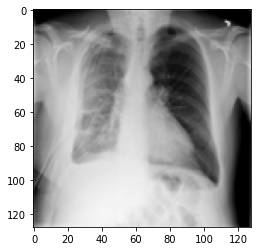

disease detected :Lung_Opacity
Actual disease :Lung_Opacity


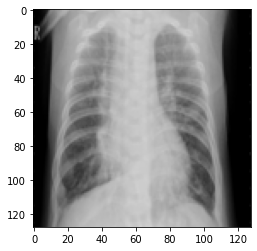

disease detected :Viral_Pneumonia
Actual disease :Viral_Pneumonia


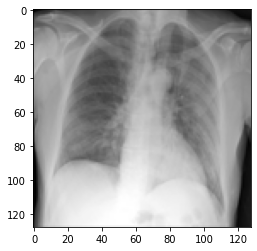

disease detected :Covid
Actual disease :Covid


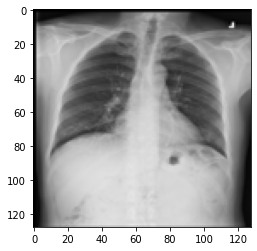

disease detected :Normal
Actual disease :Normal


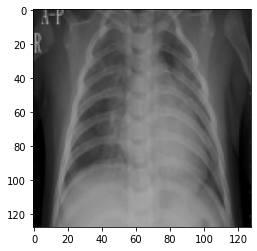

disease detected :Viral_Pneumonia
Actual disease :Viral_Pneumonia


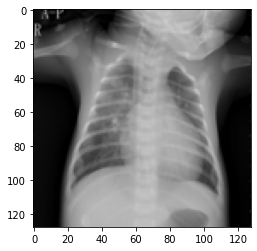

disease detected :Viral_Pneumonia
Actual disease :Viral_Pneumonia


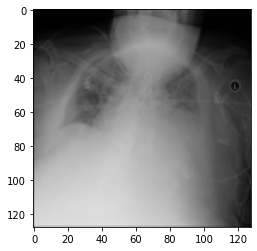

disease detected :Lung_Opacity
Actual disease :Lung_Opacity


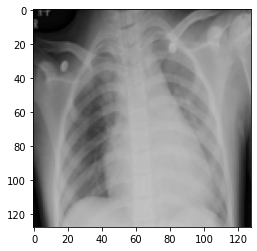

disease detected :Viral_Pneumonia
Actual disease :Viral_Pneumonia


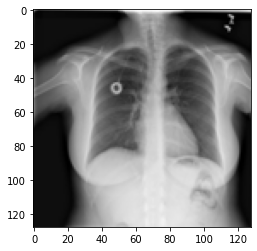

disease detected :Normal
Actual disease :Normal


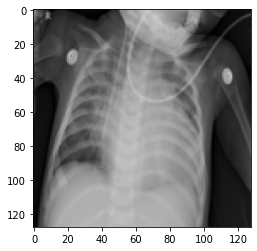

disease detected :Viral_Pneumonia
Actual disease :Viral_Pneumonia


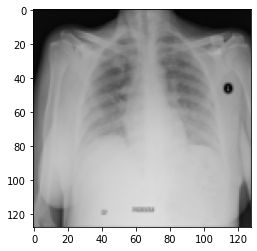

disease detected :Lung_Opacity
Actual disease :Lung_Opacity


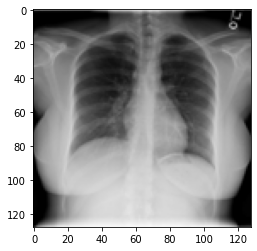

disease detected :Normal
Actual disease :Normal


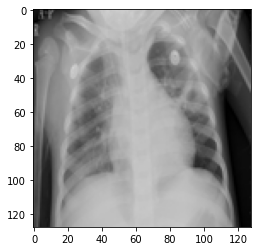

disease detected :Viral_Pneumonia
Actual disease :Viral_Pneumonia


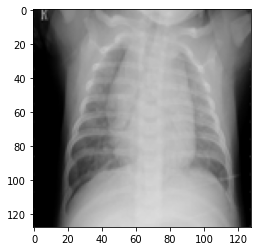

disease detected :Viral_Pneumonia
Actual disease :Viral_Pneumonia


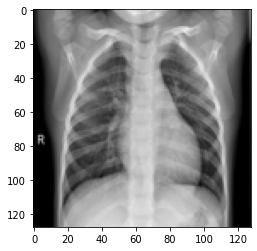

disease detected :Normal
Actual disease :Normal


In [51]:
l=0
for i in range(len(x_test)):
  l+=1
  index = np.argmax(Predictions[i])
  plt.imshow(x_test[i])
  plt.show()
  print('disease detected :'+str(labels[index]))
  print('Actual disease :'+str(labels[Y_test[i][0]]))
  if l==20:
    break

In [52]:
H=history.history

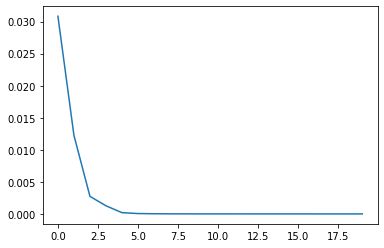

In [53]:
plt.plot(H['loss'])

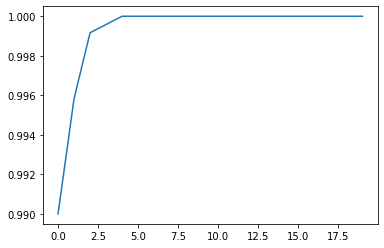

In [54]:
plt.plot(H['accuracy'])

In [55]:
predicted=[]
for i in range(len(x_test)):
    index = np.argmax(Predictions[i])
    predicted.append(index)

In [56]:
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
from sklearn.metrics import roc_auc_score

In [57]:
confusion_matrix(predicted,Y_test)

array([[210,   0,   2,   0],
       [  1, 174,   7,   6],
       [  0,   2, 178,  14],
       [  0,   4,  13, 189]])

In [41]:
accuracy_score(predicted,Y_test)

0.9275

In [42]:
print(classification_report(predicted,Y_test))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98       217
           1       0.93      0.94      0.94       177
           2       0.88      0.90      0.89       194
           3       0.91      0.90      0.90       212

    accuracy                           0.93       800
   macro avg       0.93      0.93      0.93       800
weighted avg       0.93      0.93      0.93       800

